# Exploratory Data Analysis
<a id='eda'></a>

In [1]:
import pandas as pd
import pandas_profiling
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Importing and Cleaning
<a id='imp'></a>

In [2]:
# load historical price data
btc_df = pd.read_csv('../data/raw/btc_price.csv').drop('Unnamed: 0', axis=1)
btc_df = btc_df.set_index('date')
btc_df.index = pd.to_datetime(btc_df.index)
btc_df = btc_df.reindex(index=btc_df.index[::-1])
btc_df.head()

,open,high,low,close,volume,marketcap
date,,,,,,
2014-01-01,754.97,775.35,754.97,771.40,22489400,9403308145
2014-01-02,773.44,820.31,767.21,802.39,38489500,9781073921
2014-01-03,802.85,834.15,789.12,818.72,37810100,9980135396
2014-01-04,823.27,859.51,801.67,859.51,38005000,10477362437
2014-01-05,858.55,952.40,854.52,933.53,72898496,11379660685


In [3]:
# load Google trend data
trend_df = pd.read_csv('../data/raw/btc_trend.csv').drop('Unnamed: 0', axis=1)
trend_df = trend_df.set_index('date')
trend_df = trend_df.reindex(index=trend_df.index[::-1])
trend_df.columns = ['trend']
trend_df.head()

,trend
date,
2014-01-01,3.101767
2014-01-02,3.506346
2014-01-03,3.910924
2014-01-04,3.371486
2014-01-05,3.641205


In [4]:
# merge dataframes
btc_df = btc_df.merge(trend_df, left_index=True, right_index=True)
btc_df.head()

,open,high,low,close,volume,marketcap,trend
date,,,,,,,
2014-01-01,754.97,775.35,754.97,771.40,22489400,9403308145,3.101767
2014-01-02,773.44,820.31,767.21,802.39,38489500,9781073921,3.506346
2014-01-03,802.85,834.15,789.12,818.72,37810100,9980135396,3.910924
2014-01-04,823.27,859.51,801.67,859.51,38005000,10477362437,3.371486
2014-01-05,858.55,952.40,854.52,933.53,72898496,11379660685,3.641205


In [5]:
# profiling report for easy EDA
btc_df.profile_report(style={'full_width':True})

In [6]:
# max trend value is far from the mean, possible outlier
btc_df[btc_df.trend == btc_df.trend.max()]

,open,high,low,close,volume,marketcap,trend
date,,,,,,,
2017-12-22,15898.0,15943.4,11833.0,13831.8,22197999616,231788283457,100.0


In [7]:
# check associated values
btc_df['2017-12-20':'2017-12-24']

,open,high,low,close,volume,marketcap,trend
date,,,,,,,
2017-12-20,17760.3,17934.7,16077.7,16624.6,22149699584,278528964015,70.0
2017-12-21,16642.4,17567.7,15342.7,15802.9,16516599808,264788651530,53.0
2017-12-22,15898.0,15943.4,11833.0,13831.8,22197999616,231788283457,100.0
2017-12-23,13948.7,15603.2,13828.8,14699.2,13086000128,246349213910,63.0
2017-12-24,14608.2,14626.0,12747.7,13925.8,11572299776,233414163395,48.0


This trend value point doesn't seem like an outlier and the range of values for the rest of the features seem reasonable.

## Visualization
<a id='viz'></a>

Check time series and value counts for close and trend values.

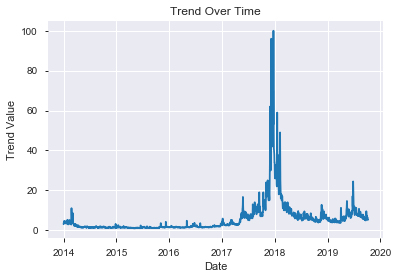

In [8]:
plt.plot(btc_df.trend)
plt.title('Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.show()

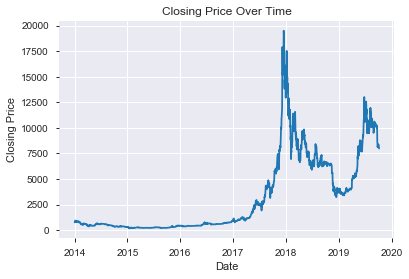

In [9]:
plt.plot(btc_df.close)
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

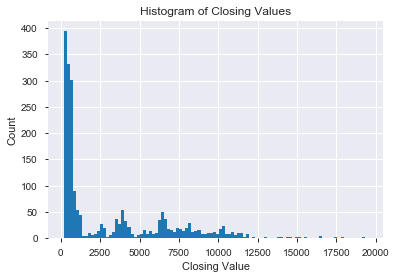

In [10]:
plt.hist(btc_df.close, bins = 100)
plt.title('Histogram of Closing Values')
plt.xlabel('Closing Value')
plt.ylabel('Count')
plt.show()

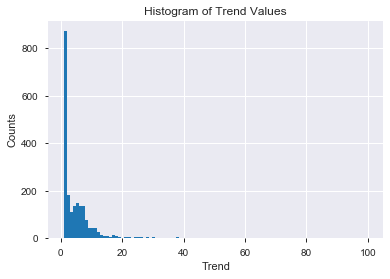

In [11]:
plt.hist(btc_df.trend, bins=100)
plt.title('Histogram of Trend Values')
plt.xlabel('Trend')
plt.ylabel('Counts')
plt.show()

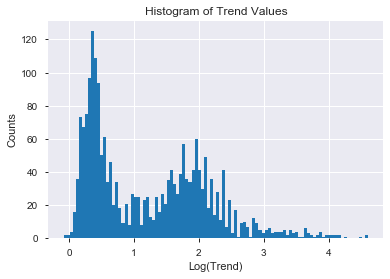

In [12]:
# log transform for better visualization
plt.hist(np.log(btc_df.trend), bins=100)
plt.title('Histogram of Trend Values')
plt.xlabel('Log(Trend)')
plt.ylabel('Counts')
plt.show()

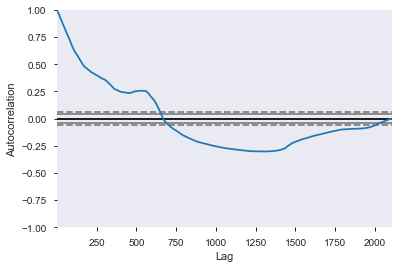

In [13]:
# check if variables are stationary
autocorrelation_plot(btc_df.close)
plt.show()

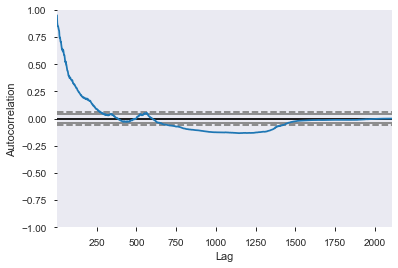

In [14]:
autocorrelation_plot(btc_df.trend)
plt.show()

We want the values we're going to use to be stationary, so close and trend values should be transformed.

## Feature Engineering
<a id='eng'></a>

Financial data is known to perform well when features such as the difference or rate of change are used. Price itself is not stationary or normally distributed so we want a better measure to feed into our model. The percent change values are also better log-scaled since they are bounded at -1.0.

In [15]:
btc_df['log_returns'] = np.log(btc_df['close']) - np.log(btc_df['close'].shift(1))
btc_df['log_trend_chg'] = np.log(btc_df['trend']) - np.log(btc_df['trend'].shift(1))
btc_df.head()

,open,high,low,close,volume,marketcap,trend,log_returns,log_trend_chg
date,,,,,,,,,
2014-01-01,754.97,775.35,754.97,771.40,22489400,9403308145,3.101767,NaN,NaN
2014-01-02,773.44,820.31,767.21,802.39,38489500,9781073921,3.506346,0.039388,0.122602
2014-01-03,802.85,834.15,789.12,818.72,37810100,9980135396,3.910924,0.020147,0.109199
2014-01-04,823.27,859.51,801.67,859.51,38005000,10477362437,3.371486,0.048620,-0.148420
2014-01-05,858.55,952.40,854.52,933.53,72898496,11379660685,3.641205,0.082611,0.076961


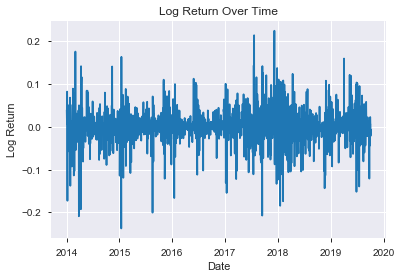

In [16]:
plt.plot(btc_df.log_returns)
plt.title('Log Return Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

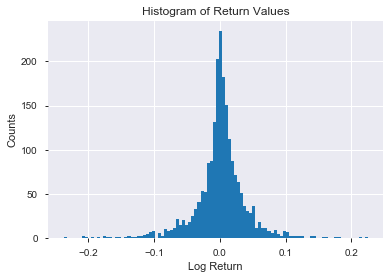

In [17]:
plt.hist(btc_df.log_returns, bins=100)
plt.title('Histogram of Return Values')
plt.xlabel('Log Return')
plt.ylabel('Counts')
plt.show()

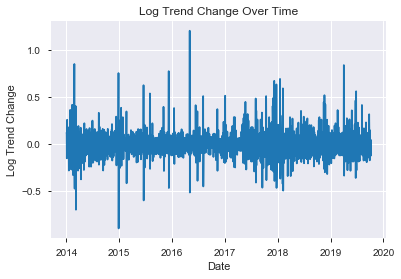

In [18]:
plt.plot(btc_df.log_trend_chg)
plt.title('Log Trend Change Over Time')
plt.xlabel('Date')
plt.ylabel('Log Trend Change')
plt.show()

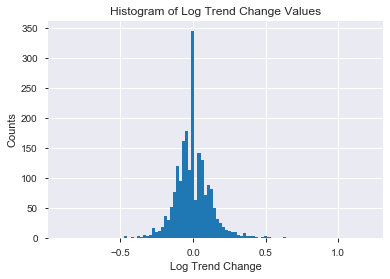

In [19]:
plt.hist(btc_df.log_trend_chg, bins=100)
plt.title('Histogram of Log Trend Change Values')
plt.xlabel('Log Trend Change')
plt.ylabel('Counts')
plt.show()

The difference values are also better suited to be log transformed, since they are bounded at -1.0.

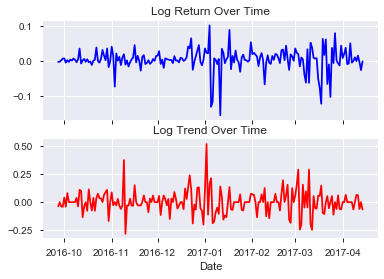

In [20]:
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(btc_df.log_returns[1000:1200], 'b', label='Log Return')
axs[0].set_title('Log Return Over Time')
axs[1].plot(btc_df.log_trend_chg[1000:1200], 'r', label='Log Trend')
axs[1].set_title('Log Trend Over Time')
plt.xlabel('Date')
plt.show()

Although the variables are not strongly correlated, we can see that when the trend value increases the return values seem to be more volatile. Although the trend metric has no distinction between "good" or "bad" trends and therefore little predictive power in terms of determining positive or negative changes in return value, the trend data may help learn about periods of volatility. 

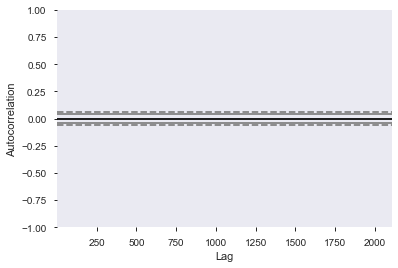

In [21]:
# check autocorrelation for transformed values
autocorrelation_plot(btc_df.log_returns)
plt.show()

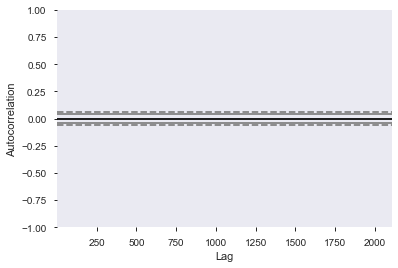

In [22]:
autocorrelation_plot(btc_df.log_trend_chg)
plt.show()

In [23]:
btc_df[['log_trend_chg', 'log_returns']].corr()

,log_trend_chg,log_returns
log_trend_chg,1.00000,-0.00668
log_returns,-0.00668,1.00000


### Save DataFrame of log return and log trend values

In [24]:
# save to csv and drop first row since they are NaN from pct_change
btc_df[['log_trend_chg', 'log_returns']][1].to_csv('../data/processed/price_trend_data.csv')

In [25]:
# Modeling notebook has Dask implemented for files larger than RAM, this preprocessing should also be scaled as such.